## Carga de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

---
## 1. Yahoo Finance
### 1.1. Descarga de datos

In [2]:
from datetime import datetime, timedelta
import yfinance as yf

ticker = 'AMD'
start_date = datetime.now() - timedelta(days=365) # solo un año
end_date = datetime.now()

amd_daily = yf.download(ticker, 
                        start = start_date,
                        end = end_date,
                        interval = '1d',
                        auto_adjust = True,
                        progress = False
                        )

amd_daily.head()

Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2024-08-05,134.820007,139.139999,121.830002,122.160004,76089400
2024-08-06,130.179993,136.440002,129.100006,135.149994,64455600
2024-08-07,128.669998,136.240005,128.369995,133.750000,54676500
2024-08-08,136.320007,136.479996,128.940002,131.970001,49037500
2024-08-09,134.270004,135.500000,132.440002,134.690002,40583000


### 1.2. Limpieza de datos
Vemos bien las columnas y el tipo de estructura que contiene

In [2]:
import pandas as pd
from pathlib import Path

# cargamos los datos
path = Path('../data').resolve()
amd_path = path / 'raw' / 'yahoo' / 'stocks' / 'AMD_latest.parquet'

amd_df = pd.read_parquet(amd_path)
amd_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/data/raw/yahoo/stocks/AMD_latest.parquet'

In [81]:
# limpiamos el header
amd_df_cleaned = amd_df.copy()
amd_df_cleaned.columns = amd_df_cleaned.columns.get_level_values(0)

## eliminamos el nombre pegado al index (Price)
amd_df_cleaned.columns.name = None

## ajustamos la columna de fecha
amd_df_cleaned.index = pd.to_datetime(amd_df_cleaned.index, dayfirst=True) # parseamos a datetime
amd_df_cleaned.index.name = "date"

## lo vemos
amd_df_cleaned.head()


,close,high,low,open,volume
date,,,,,
2022-08-05 00:00:00+02:00,102.309998,103.860001,100.980003,101.050003,93859900
2022-08-08 00:00:00+02:00,100.070000,101.800003,97.989998,100.059998,92606800
2022-08-09 00:00:00+02:00,95.540001,98.050003,93.669998,97.949997,89473700
2022-08-10 00:00:00+02:00,99.050003,99.349998,95.610001,98.449997,83416100
2022-08-11 00:00:00+02:00,98.120003,102.370003,98.000000,99.930000,77516900


In [86]:
# creamos nuevas columnas 
gap_threshold = 0.01  # umbral para considerar un gap significativo
amd_df_cleaned['daily_return'] = amd_df_cleaned['close'].pct_change()
amd_df_cleaned['range'] = amd_df_cleaned['high']- amd_df_cleaned['low']
amd_df_cleaned['is_gap'] = (amd_df_cleaned['open'] - amd_df_cleaned['close'].shift(1)).abs() > gap_threshold

# tratamos los nuloste
## vemos si hay nulos
print('número de NaNs:', amd_df_cleaned.isna().sum())

## si los hay, los eliminamos
if amd_df_cleaned.isna().sum().sum() > 0:
    amd_df_cleaned = amd_df_cleaned.dropna()

# guardamos el dataframe limpio
amd_cleaned_path = path / 'processed' / 'AMD_clean.parquet'
amd_df_cleaned.to_parquet(amd_cleaned_path)

número de NaNs: close           0
high            0
low             0
open            0
volume          0
daily_return    1
range           0
is_gap          0
dtype: int64


In [88]:
amd_df_cleaned.head(10)

,close,high,low,open,volume,daily_return,range,is_gap
date,,,,,,,,
2022-08-12 00:00:00+02:00,100.830002,101.400002,98.480003,99.199997,72316300,0.027619,2.919998,True
2022-08-15 00:00:00+02:00,101.010002,101.849998,99.800003,100.510002,61327100,0.001785,2.049995,True
2022-08-16 00:00:00+02:00,100.199997,101.449997,98.320000,100.839996,60220700,-0.008019,3.129997,True
2022-08-17 00:00:00+02:00,98.269997,99.639999,96.730003,99.260002,63735600,-0.019261,2.909996,True
2022-08-18 00:00:00+02:00,100.440002,101.070000,96.730003,97.739998,76059500,0.022082,4.339996,True
2022-08-19 00:00:00+02:00,95.949997,99.250000,94.589996,98.669998,67221700,-0.044703,4.660004,True
2022-08-22 00:00:00+02:00,92.839996,95.019997,92.360001,94.400002,61837300,-0.032413,2.659996,True
2022-08-23 00:00:00+02:00,92.489998,94.440002,92.110001,92.389999,52927000,-0.003770,2.330002,True
2022-08-24 00:00:00+02:00,92.730003,93.379997,90.900002,92.209999,56520400,0.002595,2.479996,True


### 1.3. Visualización de los datos

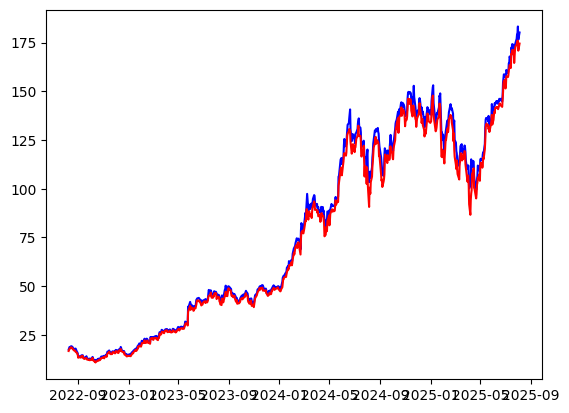

In [97]:
import matplotlib.pyplot as plt

nvda_path = Path("__file__").resolve().parents[1] / "data" / "processed" / "NVDA_1d_latest.parquet"
nvda_df = pd.read_parquet(nvda_path)

plt.plot( nvda_df.index, nvda_df['high'], 'b')
plt.plot(nvda_df.index, nvda_df['low'], 'r')

## Validación de los datos
Los datos de Forex parecen inconsistentes en sus relaciones entre precios. Vamos a ver por qué.

In [17]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd()))
from src.processing.validation import ohlc_violation_report

path = Path("__file__").resolve().parents[1]
fx_path = path / "data" / "processed" / "EURUSD=X_1d_latest.parquet"

fx_df = pd.read_parquet(fx_path)

ohlc_violation_report(fx_df)



Resumen por tipo:
 A_low>high       0
B_open>high     11
C_open<low       8
D_close>high    11
E_close<low      8
dtype: int64

Top ejemplos:


,A_low>high,B_open>high,C_open<low,D_close>high,E_close<low,any,d_l_h,d_o_h,d_o_l,d_c_h,d_c_l
date,,,,,,,,,,,
2022-12-26 00:00:00+01:00,False,True,False,True,False,True,-0.002821,0.003064,0.003064,0.003064,0.005885
2023-05-25 00:00:00+02:00,False,True,False,True,False,True,-0.004423,0.000312,0.000312,0.000312,0.004735
2023-08-02 00:00:00+02:00,False,True,False,True,False,True,-0.008726,0.000085,0.000085,0.000085,0.008811
2023-08-28 00:00:00+02:00,False,False,True,False,True,True,-0.002197,-0.002395,-0.002395,-0.002395,-0.000198
2023-12-04 00:00:00+01:00,False,True,False,True,False,True,-0.008165,0.000083,0.000083,0.000083,0.008247
2023-12-20 00:00:00+01:00,False,True,False,True,False,True,-0.004407,0.000133,0.000133,0.000133,0.004539
2024-01-01 00:00:00+01:00,False,True,False,True,False,True,-0.001342,0.000244,0.000244,0.000244,0.001587
2024-03-14 00:00:00+01:00,False,True,False,True,False,True,-0.007059,0.000060,0.000060,0.000060,0.007119
2024-06-20 00:00:00+02:00,False,True,False,True,False,True,-0.004282,0.000116,0.000116,0.000116,0.004398


Las diferencias máximas son de $\sim 3\cdot 10^{-3}$. Voy a suponer que es error de Yahoo en el redondeo de decimales. Pondremos la tolerancia a un nivel similar. 

---
## 2. IBKR
Usaré *ib_insysn* para automatizarlo y que descargue datos. Posiblemente que también pueda ejecutar órdenes. Es importante saber que tenemos que estar corriendo o TWS o IBG. También definir el cliente que queremos usar (live/paper). Los puertos en IBG son 4001/4002.


In [7]:
from ib_insync import IB, Stock 
import nest_asyncio
nest_asyncio.apply() # esto es necesario para que funcione en Jupyter Notebook

# primero creamos el wrapper
ib = IB()
ib.connect(host='127.0.0.1', port=4002, clientId=1) # puerto 4002 para paper trading

# vemos las cuentas disponibles
accounts = ib.managedAccounts()
print('Cuentas:', accounts)

# vemos el portfolio de la cuenta seleccionada
portfolio = ib.portfolio()
for item in portfolio:
    print(item)

# desconectamos
ib.disconnect()

Cuentas: ['DU9782002']
PortfolioItem(contract=Stock(conId=265598, symbol='AAPL', right='0', primaryExchange='NASDAQ', currency='USD', localSymbol='AAPL', tradingClass='NMS'), position=1000.0, marketPrice=202.30000305, marketValue=202300.0, averageCost=205.745, unrealizedPNL=-3445.0, realizedPNL=0.0, account='DU9782002')
PortfolioItem(contract=Stock(conId=272093, symbol='MSFT', right='0', primaryExchange='NASDAQ', currency='USD', localSymbol='MSFT', tradingClass='NMS'), position=1000.0, marketPrice=523.72998045, marketValue=523729.98, averageCost=398.205, unrealizedPNL=125524.98, realizedPNL=0.0, account='DU9782002')


In [10]:
# volvermos a conectar
ib.connect(host='127.0.0.1', port=4002, clientId=1)

contract = Stock('AAPL', 'SMART', 'USD')

market_data = ib.reqMktData(contract, snapshot=True, regulatorySnapshot=False)
ib.sleep(2)

print('Bid:', market_data.bid)
print('Ask:', market_data.ask)
print('Last:', market_data.last)
print('High:', market_data.high)
print('Low:', market_data.low)
print('Close:', market_data.close)
print('Open:', market_data.open)
print('Volume:', market_data.volume)

ib.disconnect()

Bid: -1.0
Ask: -1.0
Last: nan
High: nan
Low: nan
Close: 207.57
Open: nan
Volume: 0.0


También se pueden ejecutar órdenes dada una condición (señales)

## 3. Polygon.io
Principalmente para datos de opciones. Usaremos la REST API ya que nos vale con datos estáticos. Si quisieramos datos live, también tiene un WebSocket API.

In [14]:
from polygon import RESTClient
from dotenv import load_dotenv
import os
load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")

client = RESTClient(API_KEY)
status = client.get_market_status()
print(status)

MarketStatus(after_hours=False, currencies=MarketCurrencies(crypto='open', fx='open'), early_hours=True, exchanges=MarketExchanges(nasdaq='extended-hours', nyse='extended-hours', otc='extended-hours'), indicesGroups=MarketIndices(s_and_p='open', societe_generale='open', cgi='open', msci='closed', ftse_russell='closed', mstar='open', mstarc='open', cccy='open', nasdaq='open', dow_jones='closed'), market='extended-hours', server_time='2025-07-28T09:21:49-04:00')


Vamos a obtener una cadena de opciones de AMD.

In [ ]:
# definimos el subyacente y construimos la URL
underlying = "AMD"
url = f"https://api.polygon.io/v3/snapshot/options/{underlying}?apiKey={API_KEY}&limit=100"

# realiazamos la petición
import requests
resp = requests.get(url)
resp.raise_for_status()  # Lanza un error si la petición falla

# extraemos el array 'results' y lo convertimos en DataFrame
payload = resp.json()
df = pd.DataFrame(payload.get("results", []))

# mostramos las primeras filas
df.head()

,day,details,greeks,implied_volatility,open_interest,underlying_asset
0,"{'change': 0, 'change_percent': 0, 'close': 12...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9938195518432306, 'gamma': 0.00014...",6.345964,1,{'ticker': 'AMD'}
1,{},"{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9945585702926889, 'gamma': 0.00014...",5.679427,0,{'ticker': 'AMD'}
2,{},"{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9901712357238673, 'gamma': 0.00024...",5.698157,0,{'ticker': 'AMD'}
3,"{'change': 0, 'change_percent': 0, 'close': 87...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9916595396760842, 'gamma': 0.00023...",5.036632,1,{'ticker': 'AMD'}
4,"{'change': 0, 'change_percent': 0, 'close': 10...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9932230976979625, 'gamma': 0.00022...",4.483868,2,{'ticker': 'AMD'}
5,"{'change': 0, 'change_percent': 0, 'close': 90...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9915220578839546, 'gamma': 0.00028...",4.241112,3,{'ticker': 'AMD'}
6,"{'change': 0, 'change_percent': 0, 'close': 76...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9929296061528895, 'gamma': 0.00027...",3.806186,5,{'ticker': 'AMD'}
7,"{'change': 0, 'change_percent': 0, 'close': 91...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9882466209158458, 'gamma': 0.00043...",3.767654,2,{'ticker': 'AMD'}
8,"{'change': 0, 'change_percent': 0, 'close': 85...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.991145642145814, 'gamma': 0.000388...",3.300064,33,{'ticker': 'AMD'}
9,"{'change': 0, 'change_percent': 0, 'close': 80...","{'contract_type': 'call', 'exercise_style': 'a...","{'delta': 0.9905390692179861, 'gamma': 0.00044...",3.051855,10,{'ticker': 'AMD'}


(10, 6)
